In [1]:
import os
import pathlib
import sys
from itertools import combinations

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import tifffile
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from matplotlib.colors import BoundaryNorm, ListedColormap
from notebook_init_utils import bandicoot_check, init_notebook
from skimage import io
from technical_analysis_segmentation_utils import (
    convert_indexed_mask_to_binary_mask,
    extract_IOU,
    signed_xor_3color,
)

root_dir, in_notebook = init_notebook()

if in_notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
well_fovs = ["F4-2", "F4-3"]

NF0037_T1Z1_path = pathlib.Path(
    f"{image_base_dir}/data/NF0037_T1-Z-1/segmentation_masks/"
).resolve(strict=True)
NF0037_T1Z0_5_path = pathlib.Path(
    f"{image_base_dir}/data/NF0037_T1-Z-0.5/segmentation_masks/"
).resolve(strict=True)
NF0037_T1Z0_2_path = pathlib.Path(
    f"{image_base_dir}/data/NF0037_T1-Z-0.2/segmentation_masks/"
).resolve(strict=True)
NF0037_T1Z0_1_path = pathlib.Path(
    f"{image_base_dir}/data/NF0037_T1-Z-0.1/segmentation_masks/"
).resolve(strict=True)

In [3]:
# set up output dictionary for IOU results
iou_results = {
    "well_fov": [],
    "z_comparison": [],
    "IOU": [],
    "compartment": [],
    "volume_ratio": [],
}

per_compartment_volume = {
    "well_fov": [],
    "z_slice_step": [],
    "compartment": [],
    "volume": [],
}

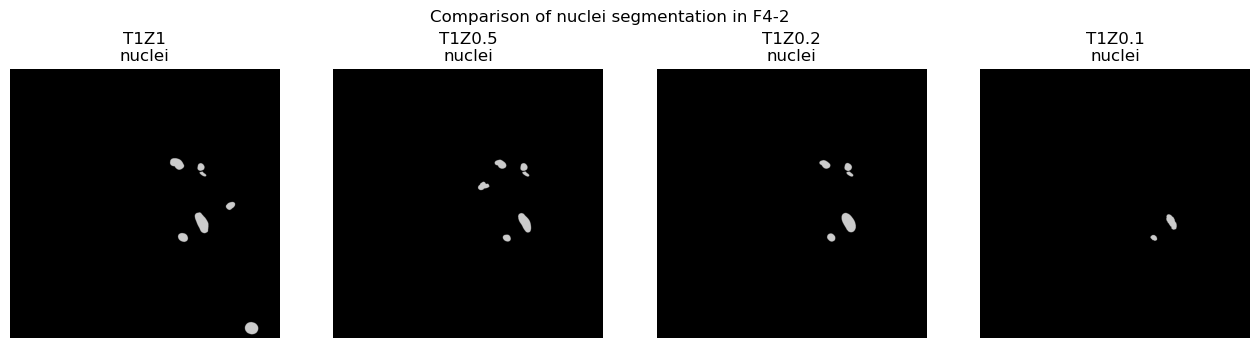

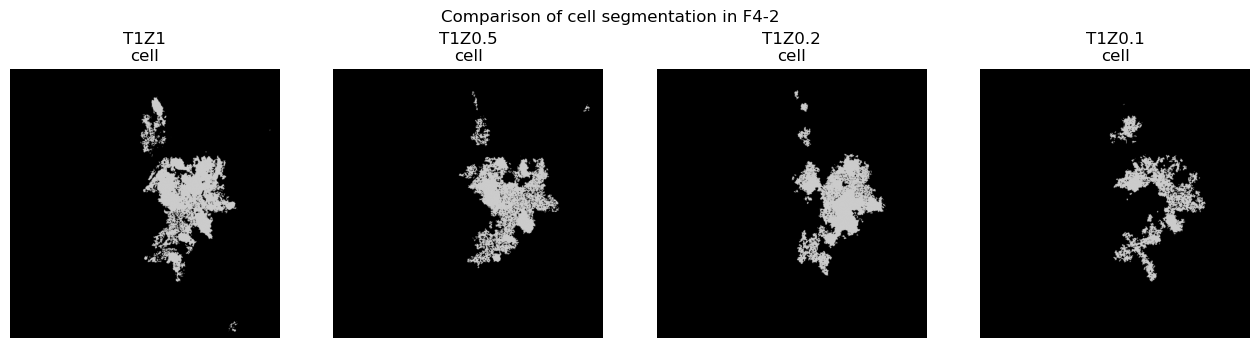

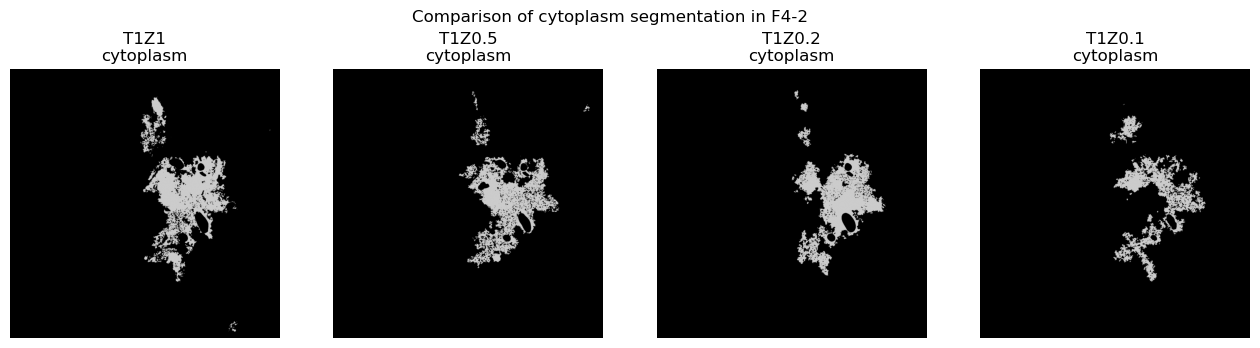

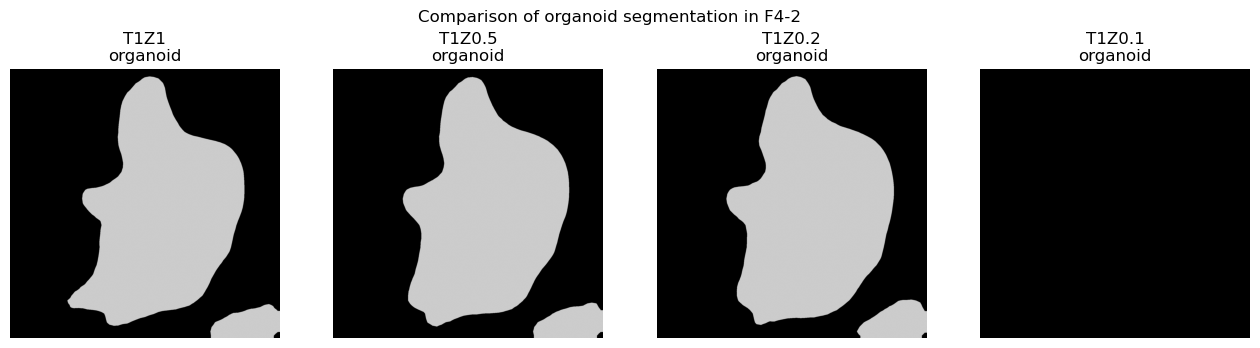

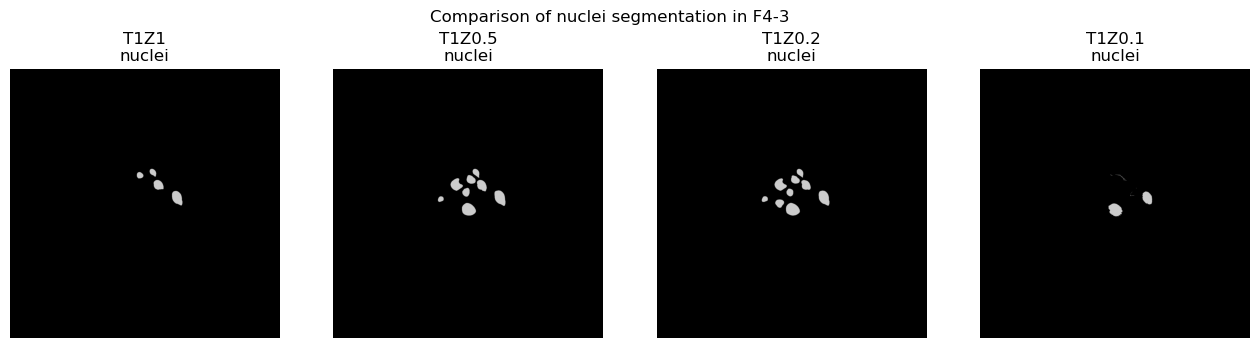

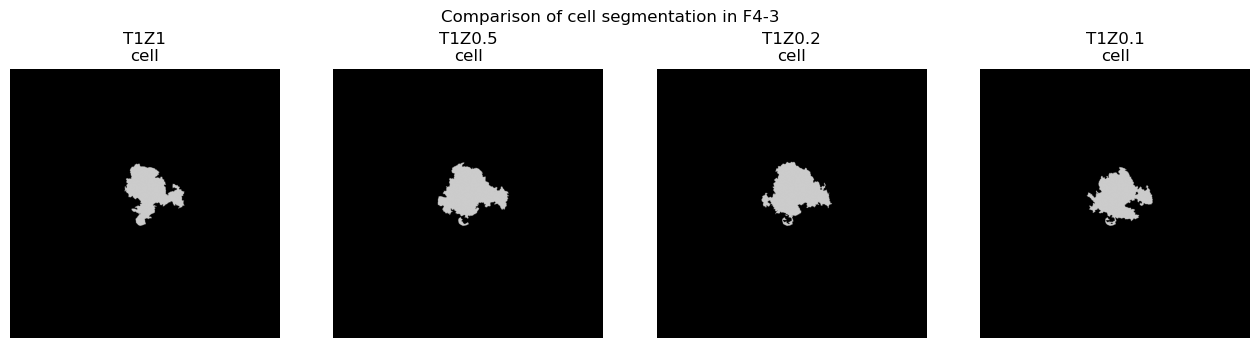

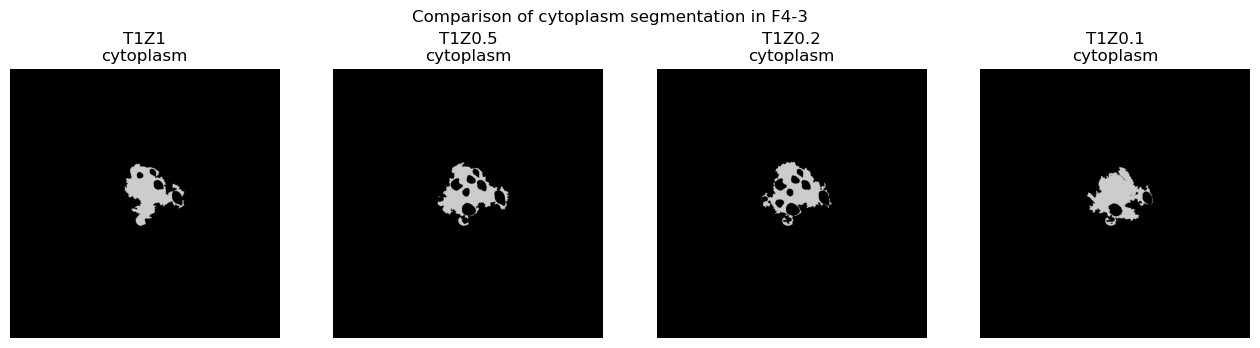

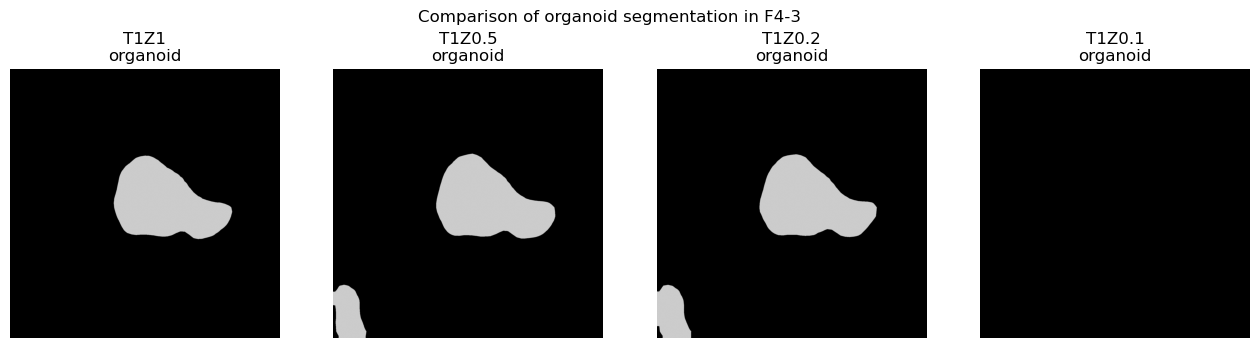

In [ ]:
# set eps to avoid division by zero
for well_fov in well_fovs:
    for compartment in ["nuclei", "cell", "cytoplasm", "organoid"]:
        # parse for the correct files
        Z1_files = list(pathlib.Path(f"{NF0037_T1Z1_path}/{well_fov}").glob("*.tif*"))
        Z0_5_files = list(
            pathlib.Path(f"{NF0037_T1Z0_5_path}/{well_fov}").glob("*.tif*")
        )
        Z0_2_files = list(
            pathlib.Path(f"{NF0037_T1Z0_2_path}/{well_fov}").glob("*.tif*")
        )
        Z0_1_files = list(
            pathlib.Path(f"{NF0037_T1Z0_1_path}/{well_fov}").glob("*.tif*")
        )

        # load the images
        for file in Z1_files:
            if compartment in str(file):
                mask_T1Z1 = read_zstack_image(file)
        for file in Z0_5_files:
            if compartment in str(file):
                mask_T1Z0_5 = read_zstack_image(file)
        for file in Z0_2_files:
            if compartment in str(file):
                mask_T1Z0_2 = read_zstack_image(file)
        for file in Z0_1_files:
            if compartment in str(file):
                mask_T1Z0_1 = read_zstack_image(file)

        # --- sample the masks to have the same number of z-slices
        mask_T1Z1_sampled = mask_T1Z1.copy()
        mask_T1Z0_5_sampled = mask_T1Z0_5[::2, :, :].copy()
        mask_T1Z0_2_sampled = mask_T1Z0_2[::5, :, :].copy()
        mask_T1Z0_1_sampled = mask_T1Z0_1[::10, :, :].copy()
        assert (
            mask_T1Z1_sampled.shape[0]
            == mask_T1Z0_5_sampled.shape[0]
            == mask_T1Z0_2_sampled.shape[0]
            == mask_T1Z0_1_sampled.shape[0]
        ), "Sampled masks do not have the same number of z-slices"

        # set the masks in a dictionary for pairwise comparison
        mask_dict = {
            "T1Z1": mask_T1Z1_sampled,
            "T1Z0.5": mask_T1Z0_5_sampled,
            "T1Z0.2": mask_T1Z0_2_sampled,
            "T1Z0.1": mask_T1Z0_1_sampled,
        }

        for (name1, mask1), (name2, mask2) in combinations(mask_dict.items(), 2):
            iou = extract_IOU(
                convert_indexed_mask_to_binary_mask(mask1),
                convert_indexed_mask_to_binary_mask(mask2),
            )
            volume_ratio = mask1.sum() / mask2.sum() if mask2.sum() != 0 else 0
            iou_results["well_fov"].append(well_fov)
            iou_results["z_comparison"].append(f"{name1} vs {name2}")
            iou_results["IOU"].append(iou)
            iou_results["compartment"].append(compartment)
            iou_results["volume_ratio"].append(volume_ratio)

        # show the masks compared
        if well_fov == "F4-2":
            slice_to_plot = mask_T1Z1_sampled.shape[0] // 2
        elif well_fov == "F4-3":
            slice_to_plot = mask_T1Z1_sampled.shape[0] - 1
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 4, 1)
        plt.title(f"T1Z1\n{compartment}")
        plt.imshow(mask_T1Z1_sampled[slice_to_plot, :, :], cmap="nipy_spectral")
        plt.axis("off")
        plt.subplot(1, 4, 2)
        plt.title(f"T1Z0.5\n{compartment}")
        plt.imshow(mask_T1Z0_5_sampled[slice_to_plot, :, :], cmap="nipy_spectral")
        plt.axis("off")
        plt.subplot(1, 4, 3)
        plt.title(f"T1Z0.2\n{compartment}")
        plt.imshow(mask_T1Z0_2_sampled[slice_to_plot, :, :], cmap="nipy_spectral")
        plt.axis("off")
        plt.subplot(1, 4, 4)
        plt.title(f"T1Z0.1\n{compartment}")
        plt.imshow(mask_T1Z0_1_sampled[slice_to_plot, :, :], cmap="nipy_spectral")
        plt.axis("off")
        plt.suptitle(f"Comparison of {compartment} segmentation in {well_fov}")
        plt.show()

        mask_T1Z1_sampled[mask_T1Z1_sampled > 0] = 1
        mask_T1Z0_5_sampled[mask_T1Z0_5_sampled > 0] = 1
        mask_T1Z0_2_sampled[mask_T1Z0_2_sampled > 0] = 1
        mask_T1Z0_1_sampled[mask_T1Z0_1_sampled > 0] = 1

        per_compartment_volume["well_fov"].append(well_fov)
        per_compartment_volume["z_slice_step"].append("T1Z1")
        per_compartment_volume["compartment"].append(compartment)
        per_compartment_volume["volume"].append(mask_T1Z1_sampled.sum())
        per_compartment_volume["well_fov"].append(well_fov)
        per_compartment_volume["z_slice_step"].append("T1Z0.5")
        per_compartment_volume["compartment"].append(compartment)
        per_compartment_volume["volume"].append(mask_T1Z0_5_sampled.sum())
        per_compartment_volume["well_fov"].append(well_fov)
        per_compartment_volume["z_slice_step"].append("T1Z0.2")
        per_compartment_volume["compartment"].append(compartment)
        per_compartment_volume["volume"].append(mask_T1Z0_2_sampled.sum())
        per_compartment_volume["well_fov"].append(well_fov)
        per_compartment_volume["z_slice_step"].append("T1Z0.1")
        per_compartment_volume["compartment"].append(compartment)
        per_compartment_volume["volume"].append(mask_T1Z0_1_sampled.sum())

In [21]:
iou_results_df = pd.DataFrame(iou_results)
per_compartment_volume_df = pd.DataFrame(per_compartment_volume)
# make compartment a categorical variable
iou_results_df["compartment"] = pd.Categorical(
    iou_results_df["compartment"],
    categories=["organoid", "nuclei", "cytoplasm", "cell"],
    ordered=True,
)

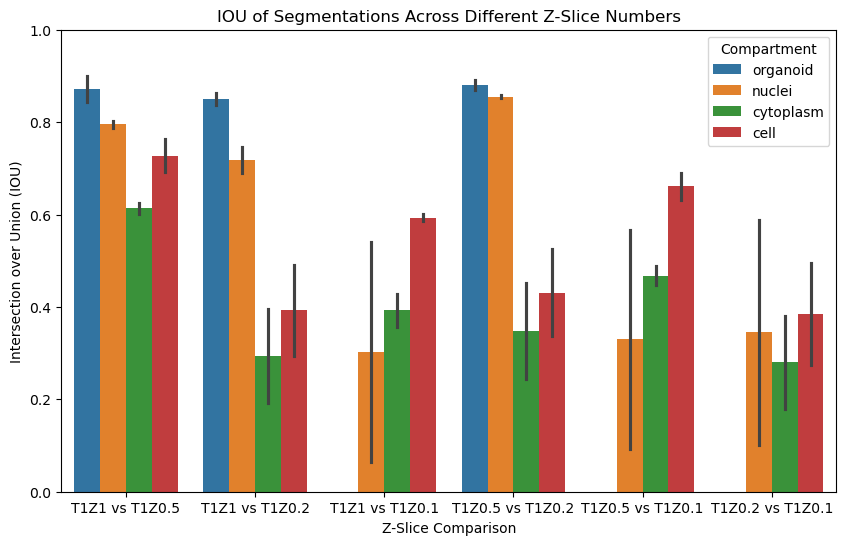

In [22]:
# plot the IOU across z-slice comparisons
plt.figure(figsize=(10, 6))
sns.barplot(
    data=iou_results_df,
    x="z_comparison",
    y="IOU",
    hue="compartment",
)
plt.title("IOU of Segmentations Across Different Z-Slice Numbers")
plt.ylabel("Intersection over Union (IOU)")
plt.xlabel("Z-Slice Comparison")
plt.ylim(0, 1)
plt.legend(title="Compartment")
plt.show()

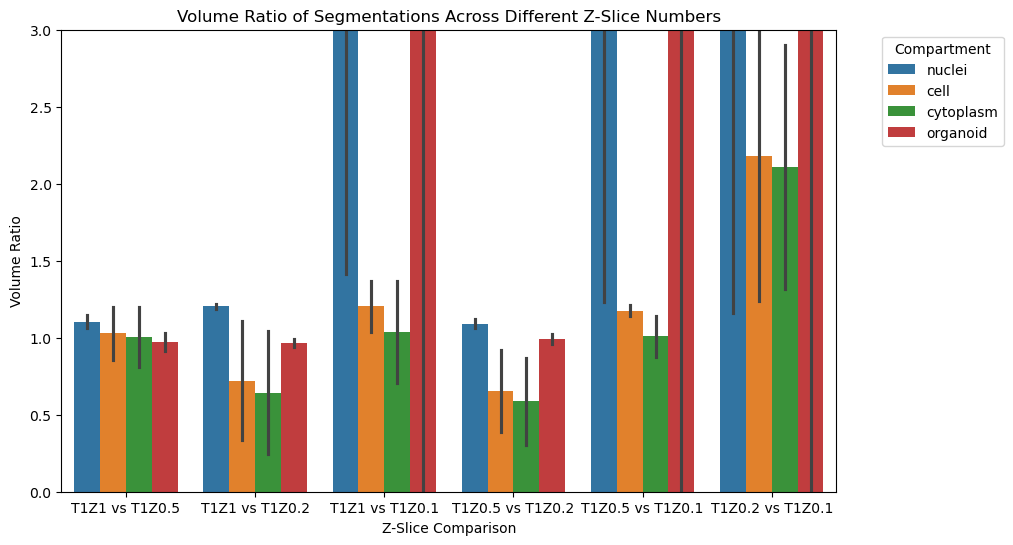

In [16]:
# plot the IOU across z-slice comparisons
plt.figure(figsize=(10, 6))
sns.barplot(
    data=iou_results_df,
    x="z_comparison",
    y="volume_ratio",
    hue="compartment",
)
plt.title("Volume Ratio of Segmentations Across Different Z-Slice Numbers")
plt.ylabel("Volume Ratio")
plt.xlabel("Z-Slice Comparison")
plt.ylim(0, 3)
plt.legend(title="Compartment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [11]:
per_compartment_volume_df
# normalize per compartment volumes (min-max normalization)
per_compartment_volume_df["normalized_volume"] = per_compartment_volume_df.groupby(
    "compartment"
)["volume"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

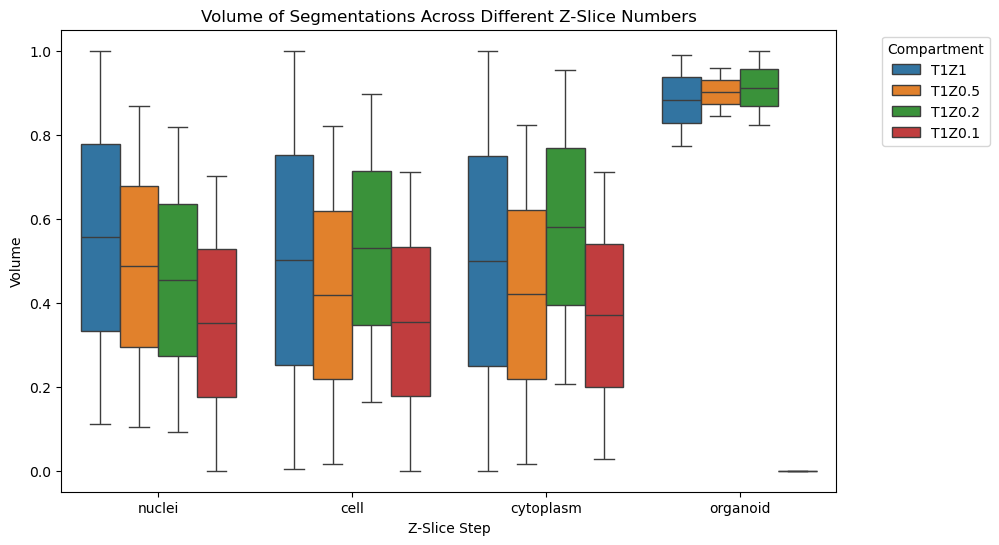

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=per_compartment_volume_df,
    x="compartment",
    y="normalized_volume",
    hue="z_slice_step",
)
plt.title("Volume of Segmentations Across Different Z-Slice Numbers")
plt.ylabel("Volume")
plt.xlabel("Z-Slice Step")
plt.legend(title="Compartment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()